### Connect to the google cloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Tools

In [ ]:
!pip install -q einops datasets tqdm

import math
from inspect import isfunction
from functools import partial
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti

+ inspect：用於檢查對象屬性的模組。
+ functools：包含了一些有用的函數，如partial，它用於將一個函數的一部分參數固定住，以創建新的函數。
+ %matplotlib inline：這是一個Jupyter Notebook的魔法命令，用於在Notebook中顯示Matplotlib繪圖。
+ matplotlib.pyplot：Matplotlib庫的一個子模組，用於繪圖和視覺化。
+ tqdm.auto：用於創建進度條的模組。
+ einops：前面已經安裝的einops庫的匯入

最後，程式碼匯入了PyTorch庫的一些模組，包括torch、nn（神經網絡模組）、einsum和functional。這些模組是用於深度學習和神經網絡建模的基本工具。

### Model

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

+ exists(x) 函數：

  這個函數檢查變數 x 是否存在，如果 x 不是 None，則返回 True，否則返回 False。
+ default(val, d) 函數：

  這個函數用來處理默認值。如果 val 存在（不是 None），則返回 val。否則，如果 d 是一個函數，則調用 d() 並返回其結果，否則直接返回 d。
+ Residual 類別：

  這是一個自定義的PyTorch神經網絡模塊。它的初始化方法 __init__ 接受一個函數 fn 作為參數，然後在前向傳播方法 forward 中將輸入 x 傳遞給函數 fn，然後將結果與 x 相加並返回。
+ Upsample(dim) 函數：

  這是一個用於上採樣的函數，它創建一個二維轉置卷積層（nn.ConvTranspose2d），其輸入和輸出通道數都是 dim，卷積核大小為 4x4，步幅為 2，填充為 1。通常用於將輸入圖像的尺寸增加一倍。
+ Downsample(dim) 函數：

  這是一個用於下採樣的函數，它創建一個二維卷積層（nn.Conv2d），其輸入和輸出通道數都是 dim，卷積核大小為 4x4，步幅為 2，填充為 1。通常用於將輸入圖像的尺寸減小一半。

這些自定義函數和神經網絡模塊可能是在深度學習模型中使用的一些工具，用於定義網絡架構的不同部分，例如上採樣和下採樣層，以及殘差連接。這些工具可以用於構建自定義的神經網絡模型。

### Position embeddings


In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

+ __init__ 方法：

  在初始化時，它接受一個參數 dim，表示嵌入維度（embedding dimension）。這將決定生成的位置嵌入的維度。
+ forward 方法：

  這是該模塊的前向傳播方法。它接受一個名為 time 的輸入，通常代表時間步或序列中的位置。該方法的目的是根據輸入的時間信息生成對應的正弦和餘弦位置嵌入。

+ device = time.device：
  獲取輸入 time 張量的設備（device）信息，以確保生成的嵌入與輸入在相同的設備上。

+ half_dim = self.dim // 2：
  計算嵌入維度的一半，因為正弦和餘弦嵌入總是成對出現。

+ embeddings = math.log(10000) / (half_dim - 1)：
  計算一個常數，它將用於生成正弦和餘弦的週期。

+ embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)：
  生成正弦和餘弦的週期性數值。使用指數函數計算這些值，其中 torch.arange(half_dim, device=device) 生成一個張量，其中包含了 0 到 half_dim-1 的索引值，這些值將被乘以 -embeddings，然後再進行指數運算。

+ embeddings = time[:, None] * embeddings[None, :]：
  將輸入的時間 time 與生成的週期性數值相乘，以生成最終的位置嵌入。[:, None] 和 [None, :] 的用法是為了確保張量的維度匹配。

+ embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)：
  將正弦和餘弦嵌入連接在一起，形成最終的位置嵌入。在這裡，sin() 和 cos() 函數被應用於週期性數值以生成正弦和餘弦嵌入，然後使用 torch.cat 函數按維度 -1（最後一個維度）連接這些嵌入。

+ 最後，方法返回生成的位置嵌入。
總之，這個自定義模塊可以用於將時間或位置信息引入神經網絡中，通常在序列建模的上下文中使用。正弦和餘弦嵌入可以幫助模型學習到序列中不同位置的相對關係。

### ResNet/ConvNeXT block


In [ ]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module



In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization



In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Unconditional U-Net

In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Defining the forward diffusion process

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_end = 0.0001
    beta_start = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [ ]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

We'll illustrate with a cats image how noise is added at each time step of the diffusion process.

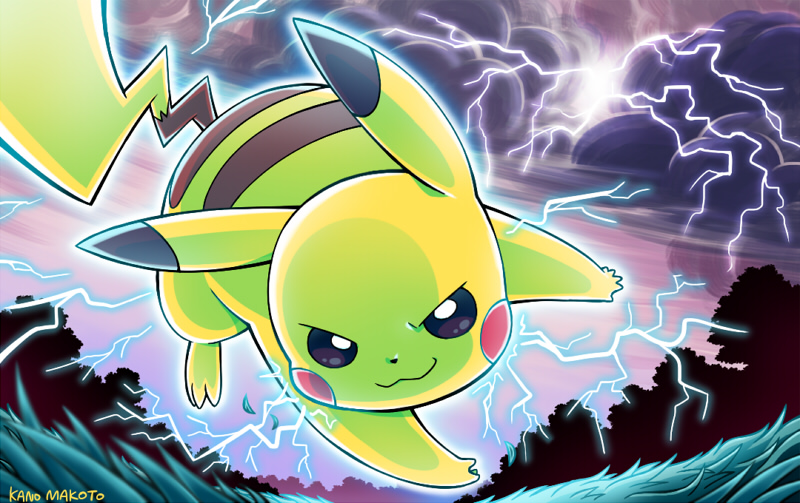

In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
ur2 = 'https://static1.e926.net/data/15/b4/15b437918c37a5809555f46ca572a5d8.jpg'
image = Image.open(requests.get(ur2, stream=True).raw)
image

In [ ]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

In [ ]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

Let's verify this:

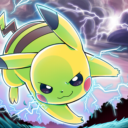

In [ ]:
reverse_transform(x_start.squeeze())

In [ ]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [ ]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

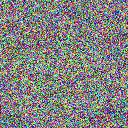

In [ ]:
# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

In [ ]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [ ]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

The `denoise_model` will be our U-Net defined above. We'll employ the Huber loss between the true and the predicted noise.

## Define a PyTorch Dataset + DataLoader



### The data set is obtained from kaggle

In [ ]:
# Download kaggle data in Google Colab
! pip install -q kaggle
from google.colab import files
files.upload()

{}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d 'spandan2/cats-faces-64x64-for-generative-models'

Dataset URL: https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models
License(s): unknown
100% 96.0M/96.0M [00:06<00:00, 18.6MB/s]
100% 96.0M/96.0M [00:06<00:00, 16.6MB/s]


In [ ]:
#! kaggle datasets download -d 'tongpython/cat-and-dog'

In [ ]:
# 建立一個名為cat_and_dog的資料夾
! mkdir catface1

In [ ]:
# 將剛剛載下來的.zip壓縮檔解壓縮進cat_and_dog資料夾裡
! unzip cats-faces-64x64-for-generative-models.zip -d catface1

串流輸出內容已截斷至最後 5000 行。
  inflating: catface1/cats/cats/5499.jpg  
  inflating: catface1/cats/cats/55.jpg  
  inflating: catface1/cats/cats/550.jpg  
  inflating: catface1/cats/cats/5500.jpg  
  inflating: catface1/cats/cats/5501.jpg  
  inflating: catface1/cats/cats/5502.jpg  
  inflating: catface1/cats/cats/5503.jpg  
  inflating: catface1/cats/cats/5504.jpg  
  inflating: catface1/cats/cats/5505.jpg  
  inflating: catface1/cats/cats/5506.jpg  
  inflating: catface1/cats/cats/5507.jpg  
  inflating: catface1/cats/cats/5508.jpg  
  inflating: catface1/cats/cats/5509.jpg  
  inflating: catface1/cats/cats/551.jpg  
  inflating: catface1/cats/cats/5510.jpg  
  inflating: catface1/cats/cats/5511.jpg  
  inflating: catface1/cats/cats/5512.jpg  
  inflating: catface1/cats/cats/5513.jpg  
  inflating: catface1/cats/cats/5514.jpg  
  inflating: catface1/cats/cats/5515.jpg  
  inflating: catface1/cats/cats/5516.jpg  
  inflating: catface1/cats/cats/5517.jpg  
  inflating: catface1/cats/cats/5518.

In [ ]:
from datasets import DatasetDict
from datasets import Dataset

In [ ]:
import os
from PIL import Image
import numpy as np

# 指定圖像文件路徑
catfacedataset = 'catface1/cats/cats/'  # 替换为实际图像文件的路径
# 创建一个字典，其中键是特征名称，值是包含特征数据的列表
data_dict = {"image": []}

# 用一个列表来存储图片数据
image_data = []
image_data_dic = DatasetDict()
# 读取图像文件

image = Image.open('catface1/cats/cats/5582.jpg')

# 显示图像
image.show()

# 可以继续对图像进行其他处理，如调整大小、旋转等
# 遍历文件夹中的所有图片文件
for filename in os.listdir(catfacedataset):
    if filename.endswith('.jpg'):
        image_path = os.path.join(catfacedataset, filename)
        img = Image.open(image_path)

        # 可以选择对图像进行处理，例如将其转换为 NumPy 数组
        #img_array = np.array(img)

        # 将处理后的图像数据添加到列表中
        #image_data.append(img_array)

        # 将图像添加到特征数据字典中
        data_dict["image"].append(img)


In [ ]:
len(data_dict["image"])

15747

In [ ]:
'''
import os
from PIL import Image
import numpy as np

# 指定图片数据集所在的文件夹
dataset = '/content/drive/MyDrive/archive/pokemon_jpg/pokemon_jpg'
# 创建一个字典，其中键是特征名称，值是包含特征数据的列表
data_dict = {"image": []}

# 用一个列表来存储图片数据
image_data = []
image_data_dic = DatasetDict()

# 遍历文件夹中的所有图片文件
for filename in os.listdir(dataset):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset, filename)
        img = Image.open(image_path)

        # 可以选择对图像进行处理，例如将其转换为 NumPy 数组
        img_array = np.array(img)

        # 将处理后的图像数据添加到列表中
        image_data.append(img_array)

        # 将图像添加到特征数据字典中
        data_dict["image"].append(img)



# image_data 现在包含了所有加载的图像数据
#image_data_dic[] = dataset.from_dict(data_dict)
'''

In [ ]:
len(data_dict['image'])

15747

In [ ]:
new_size = (48, 48)
data_resize_dic = {'image':[]}
resized_img = DatasetDict()
for i in range(12000):
  a = data_dict['image'][i].resize(new_size)
  data_resize_dic['image'].append(a)

resized_img = Dataset.from_dict(data_resize_dic)

In [ ]:
resized_img

Dataset({
    features: ['image'],
    num_rows: 12000
})

In [ ]:
type(resized_img)

datasets.arrow_dataset.Dataset

In [ ]:
resized_img['image']

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>,
 <PIL.Pn

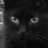

In [ ]:
resized_img['image'][100]

In [ ]:
from datasets import load_dataset

# load dataset from the hub
#dataset_fashion = load_dataset("fashion_mnist")
image_size = 48
channels = 1
batch_size = 12

In [ ]:
#dataset_fashion

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = resized_img.with_transform(transforms) #.remove_columns("label")   #留意

# create dataloader
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [ ]:
batch['pixel_values'].shape

torch.Size([12, 1, 48, 48])

<div class="output stream stdout">

    Output:
    ----------------------------------------------------------------------------------------------------
    dict_keys(['pixel_values'])

</div>

In [ ]:
type(transformed_dataset)

datasets.arrow_dataset.Dataset

## Sampling

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


### Train the model


In [ ]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
type(batch)

#batch = batch.reshape(16,1, 256, 256)  # 将批次大小从1改为16

dict

In [ ]:
from torchvision.utils import save_image

epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model,image_size=48, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)


Loss: 0.008864404633641243
Loss: 0.008538327179849148
Loss: 0.019367443397641182
Loss: 0.007739352993667126
Loss: 0.0056263417936861515
Loss: 0.009069079533219337
Loss: 0.012489549815654755
Loss: 0.014218371361494064
Loss: 0.010448568500578403
Loss: 0.011082960292696953
Loss: 0.0129963094368577
Loss: 0.00892558228224516
Loss: 0.007484199944883585
Loss: 0.01129237562417984
Loss: 0.013447299599647522
Loss: 0.009533511474728584
Loss: 0.013603621162474155
Loss: 0.010700700804591179
Loss: 0.01857908070087433
Loss: 0.007733054459095001
Loss: 0.015761230140924454
Loss: 0.015322653576731682
Loss: 0.009736827574670315
Loss: 0.011901114135980606
Loss: 0.0075730858370661736
Loss: 0.006228219717741013
Loss: 0.011971110478043556
Loss: 0.009523226879537106
Loss: 0.03198087960481644
Loss: 0.011902851983904839
Loss: 0.010212751105427742
Loss: 0.020432185381650925
Loss: 0.016782362014055252
Loss: 0.012677676975727081
Loss: 0.014700875617563725
Loss: 0.0065828897058963776
Loss: 0.006555479485541582
Loss

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

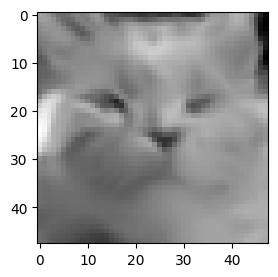

In [ ]:
# show a random one
random_index = 60
plt.figure(figsize=(3,3))
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

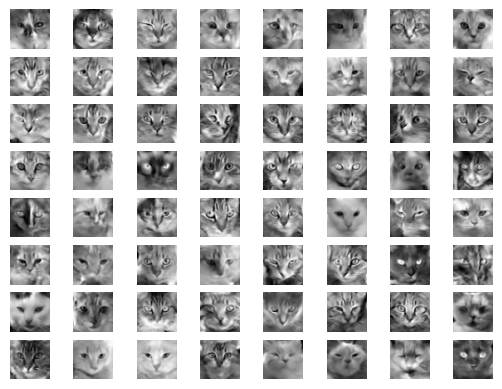

In [ ]:
# show a random one
random_index = 60
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(samples[-1][i].reshape(image_size, image_size, channels), cmap="gray")
  plt.axis('off')
# plt.figure(figsize=(3,3))
# plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

In [ ]:
len(samples)

200

In [ ]:
samples

[array([[[[-1.3088889e+00, -2.7305949e-01,  4.4526692e-02, ...,
           -1.7688026e-01, -1.0688556e+00,  8.7836099e-01],
          [ 1.5621972e-01, -3.1808609e-01,  1.3618096e+00, ...,
           -6.4347602e-02, -1.1548346e+00, -4.6834748e-02],
          [ 5.7672310e-01,  1.7114532e-01,  4.2219502e-01, ...,
           -7.7033770e-01, -3.3993813e-01, -2.0885463e+00],
          ...,
          [-1.5283471e+00,  6.9299281e-01, -2.4603167e-01, ...,
            1.1066748e+00,  2.6287714e-02,  1.6298943e+00],
          [ 4.2959678e-01,  6.4973935e-02,  4.5140815e-01, ...,
           -6.8092845e-02,  9.6119577e-01,  1.5776013e+00],
          [ 1.0424067e+00,  2.3391478e+00,  7.5192380e-01, ...,
            6.2661666e-01,  3.6362460e-01, -1.9964062e+00]]],
 
 
        [[[-7.3799068e-01,  1.8801889e-01,  3.3348101e-01, ...,
            1.4683652e-01,  5.4939520e-01, -8.1959829e-02],
          [ 5.8063608e-01, -2.6719904e-01,  1.7486732e-01, ...,
           -1.5621340e+00,  5.6515843e-02,  1.3

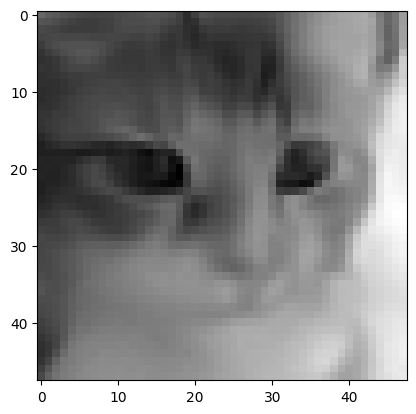

In [ ]:
import matplotlib.animation as animation

random_index = 5

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()